In [ ]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')

%matplotlib inline

import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/'
results_path = '/content/drive/My Drive/DeepLearning_2021/FinalProject/Results/'

import os
for dirname, _, filenames in os.walk(data_path):
    for i, filename in enumerate(filenames):
            print(os.path.join(dirname,filename))
            

Mounted at /content/drive
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/abengoa.csv
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/bbva.csv
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/atresmedia.csv
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/naturgy-energy.csv
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/repsol.csv
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/acerinox.csv
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/siemens-gamesa.csv
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/colonial.csv
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/ferrovial.csv
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/mapfre.csv
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/santander.csv
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/mediaset.csv
/content/drive/My Drive/DeepLearning_2021/FinalProject/

# Load Data

In [ ]:
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv(data_path+"/{}.csv".format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

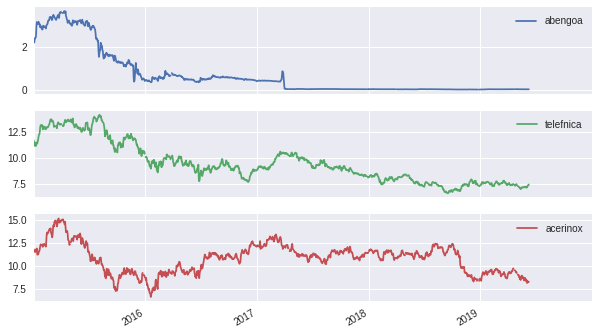

In [ ]:
dates = pd.date_range('2015-01-02','2019-12-31',freq='B')
symbols = ['abengoa','telefonica','acerinox']
df = stocks_data(symbols, dates)
df.fillna(method='pad')
df.plot(figsize=(10, 6), subplots=True);

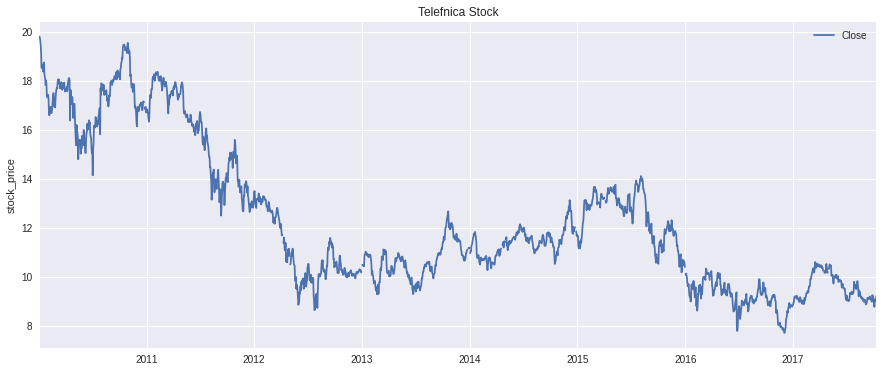

In [ ]:
dates = pd.date_range('2010-01-02','2017-10-11',freq='B')
df1=pd.DataFrame(index=dates)
df_ibm=pd.read_csv(data_path+"/telefnica.csv", parse_dates=True, index_col=0)
df_ibm=df1.join(df_ibm)
df_ibm[['Close']].plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title("Telefonica Stock")
plt.show()

In [ ]:
df_ibm=df_ibm[['Close']]
df_ibm.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2028 entries, 2010-01-04 to 2017-10-11
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1992 non-null   float64
dtypes: float64(1)
memory usage: 111.7 KB


In [ ]:
df_ibm=df_ibm.fillna(method='ffill') 

scaler = MinMaxScaler(feature_range=(-1, 1))
df_ibm['Close'] = scaler.fit_transform(df_ibm['Close'].values.reshape(-1,1))
#df_ibm

In [ ]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back, target):
    data_raw = stock.values # convert to numpy array
    x = []
    y = []
    
    #Long term prediction con 30 dias de target
    for index in range(len(data_raw) - look_back - target): 
        x.append(data_raw[index : index + look_back])
        y.append(data_raw[index + look_back : index + look_back + target])
    x = np.array(x)
    y = np.squeeze(y)   

    # 80% train 10%Dev_test 10%train_test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
    x_dev, x_test, y_dev, y_test = train_test_split(x_test, y_test, test_size=0.5, shuffle=False)
    
    return [x_train, y_train, x_dev, y_dev, x_test, y_test]

look_back = 60 # choose sequence length

target = 30

x_train, y_train, x_dev, y_dev, x_test, y_test = load_data(df_ibm, look_back,target)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_dev.shape = ',x_dev.shape)
print('y_dev.shape = ',y_dev.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1550, 60, 1)
y_train.shape =  (1550, 30)
x_dev.shape =  (194, 60, 1)
y_dev.shape =  (194, 30)
x_test.shape =  (194, 60, 1)
y_test.shape =  (194, 30)


In [ ]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_dev = torch.from_numpy(x_dev).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_dev = torch.from_numpy(y_dev).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
y_train.size(),x_train.size()

(torch.Size([1550, 30]), torch.Size([1550, 60, 1]))

# Build the structure of model

In [ ]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = target #30


# Here we define our model as a class
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(BiLSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True,bidirectional=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim*2, output_dim)

       

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        hn = hn.to(device)
        cn = cn.to(device)

    
        out = self.fc(out[:, -1, :]).to(device) 
        
        return out.to(device)
    
modelBi = BiLSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fnBi = torch.nn.MSELoss()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
modelBi = modelBi.to(device)

optimiser = torch.optim.Adam(modelBi.parameters(), lr=0.01)
print(modelBi)
print(len(list(modelBi.parameters())))
for i in range(len(list(modelBi.parameters()))):
    print(list(modelBi.parameters())[i].size())

BiLSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=30, bias=True)
)
18
torch.Size([256, 1])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([256, 1])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([256, 128])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([256, 128])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([30, 128])
torch.Size([30])


In [ ]:
# Train model
#####################
num_epochs = 1000
hist = np.zeros(num_epochs)
dev_hist = []

# Number of steps to unroll
seq_dim =look_back-1  

x_train = x_train.to(device)
y_train = y_train.to(device)
x_dev = x_dev.to(device)
y_dev = y_dev.to(device)

for t in range(num_epochs):
    
    # Forward pass
    y_train_pred = modelBi(x_train).to(device)

    loss = loss_fnBi(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    if t % 50 == 0 and t != 0:
        y_dev_pred = modelBi(x_dev).to(device)
        dev_loss = loss_fnBi(y_dev_pred, y_dev)
        print("\tDev MSE:", dev_loss.item())
        dev_hist.append(dev_loss.item())

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()
print(min(dev_hist))

Epoch  10 MSE:  0.026767628267407417
Epoch  20 MSE:  0.017846515402197838
Epoch  30 MSE:  0.01581764779984951
Epoch  40 MSE:  0.015231146477162838
Epoch  50 MSE:  0.015114507637917995
	Dev MSE: 0.015240561217069626
Epoch  60 MSE:  0.015031211078166962
Epoch  70 MSE:  0.014952224679291248
Epoch  80 MSE:  0.014888055622577667
Epoch  90 MSE:  0.014826907776296139
Epoch  100 MSE:  0.014741992577910423
	Dev MSE: 0.01764993742108345
Epoch  110 MSE:  0.014632056467235088
Epoch  120 MSE:  0.014580896124243736
Epoch  130 MSE:  0.014435287564992905
Epoch  140 MSE:  0.014650708995759487
Epoch  150 MSE:  0.014288275502622128
	Dev MSE: 0.016631439328193665
Epoch  160 MSE:  0.01413770392537117
Epoch  170 MSE:  0.013980550691485405
Epoch  180 MSE:  0.013879585079848766
Epoch  190 MSE:  0.013734868727624416
Epoch  200 MSE:  0.013757800683379173
	Dev MSE: 0.020028287544846535
Epoch  210 MSE:  0.015492190606892109
Epoch  220 MSE:  0.01485355757176876
Epoch  230 MSE:  0.014551191590726376
Epoch  240 MSE:

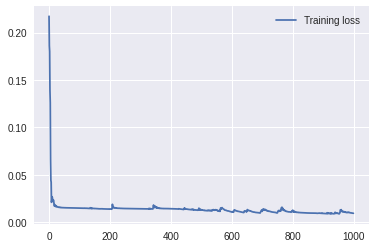

In [ ]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [ ]:
np.shape(y_train_pred)

torch.Size([1550, 30])

In [ ]:
# make predictions
x_test = x_test.to(device)
y_test_pred = modelBi(x_test)

# invert predictions
y_train_pred = y_train_pred.cpu()
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = y_train.cpu()
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = y_test_pred.cpu()
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = y_test.cpu()
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.4f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

Train Score: 0.2191 RMSE
Test Score: 0.2331 RMSE


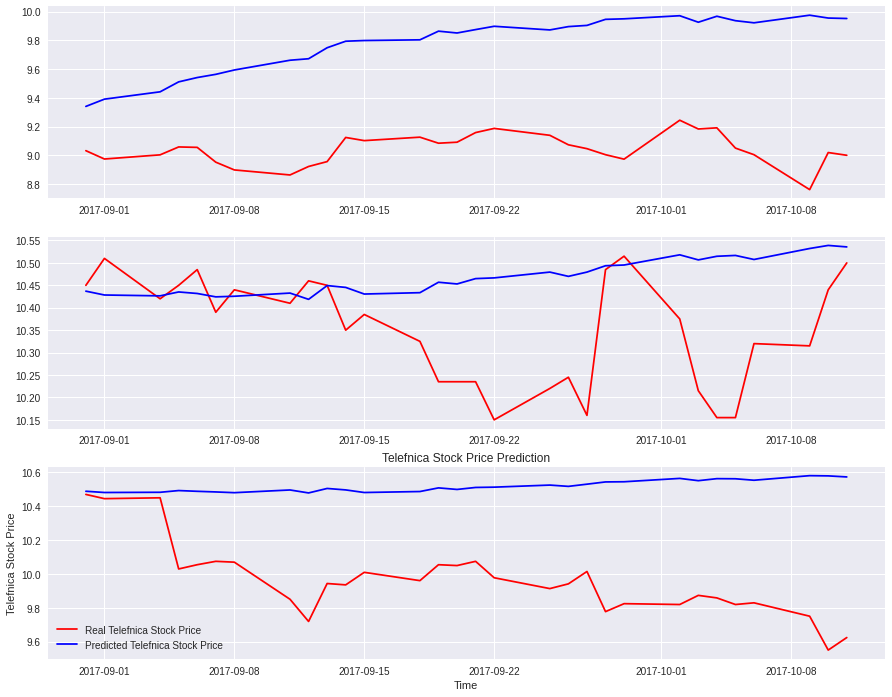

In [ ]:
# Visualising the results
figure, axes = plt.subplots(3,1,figsize=(15, 12))

#Cogemos
i = np.random.randint(len(y_test))
j = np.random.randint(len(y_test))
k = np.random.randint(len(y_test))

#Plot de la predicción de 1 mes.

axes[0].plot(df_ibm[len(df_ibm)-len(y_test[i]):].index, y_test[i], color = 'red', label = 'Real Telefonica Stock Price')
axes[0].plot(df_ibm[len(df_ibm)-len(y_test[i]):].index, y_test_pred[i], color = 'blue', label = 'Predicted Telefonica Stock Price')

axes[1].plot(df_ibm[len(df_ibm)-len(y_test[j]):].index, y_test[j], color = 'red', label = 'Real Telefonica Stock Price')
axes[1].plot(df_ibm[len(df_ibm)-len(y_test[j]):].index, y_test_pred[j], color = 'blue', label = 'Predicted Telefonica Stock Price')

axes[2].plot(df_ibm[len(df_ibm)-len(y_test[k]):].index, y_test[k], color = 'red', label = 'Real Telefonica Stock Price')
axes[2].plot(df_ibm[len(df_ibm)-len(y_test[k]):].index, y_test_pred[k], color = 'blue', label = 'Predicted Telefonica Stock Price')
#axes.xticks(np.arange(0,394,50))

plt.title('Telefonica Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Telefonica Stock Price')
plt.legend()
plt.savefig(results_path+'/telefnica_pred_OriginalBidirectionalLSTM.png')
plt.show()